##  Intro to tonal representation of data, and RTcmix 
### (1) Read in the data file ! 
### (2) No Rhythm ! time determines pitches
### (3) Got Rhythm! pitches determine time
### (4) Swelling chords

In [1]:
# import what you need ! 

import sys
sys.path.append('../2_modules/')

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pandas as pd
import subprocess as sp
from subprocess import Popen

# our modules: 
import notepicker
#import makeDataChord_v2 as mDc
import writeCmixSco_GRAN_v2 as wRT_gran
import writeCmixSco_WT_ac as wRT_wt
# _ac stands for autocheck

%matplotlib inline

# ======================================================
# autocheck for your RTcmix installation type: 
cmixStatus, cmixResult = sp.getstatusoutput("CMIX")
if cmixStatus == 0:
    cmixInstalled = True
    print("CMIX found.")
else:
    cmixInstalled = False
    print("CMIX not found, using pyGoRTcmix instead.")
# ======================================================

%matplotlib inline

CMIX not found, using pyGoRTcmix instead.


## (1) Read in the data ! 

In [2]:
! ls ../0_data_nogit/

data_readme.txt  P39A.BHZ


In [4]:
# READ IN THE DATA FILE ! ! !
#datafilename = '../0_data_nogit/breathalyzer/pizzadevils_120s.pkl'
datafilename = '../0_data_examples/breathalyzer/BA_ben_1.pkl'
breath = pd.read_pickle(datafilename) # np.loadtxt(datafilename)
print(breath[0:5])
time = breath.time_s
p1 = temp_C = breath.temp_C
p2 = humidity = breath.hum

# put the data into a dictionary: 
# (very useful, but we will also work with pandas)
data_dict = {}
data_dict['time_o'] = time  # the _o indicates these are the original values, un-re-sampled
data_dict['p1_o'] = p1

      hum  temp_C  time_s
0  46.151   20.89  0.0000
1  46.088   20.90  0.3492
2  46.025   20.90  0.7246
3  45.995   20.92  1.0998
4  45.965   20.93  1.4751


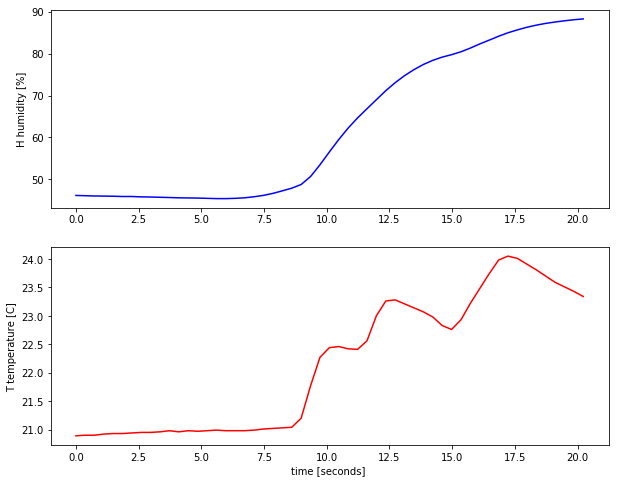

In [5]:
# PLOT THE DATA AS CURVES... 
fig = plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.plot(time,humidity,'b-')
#plt.xlabel('time')
plt.ylabel('H humidity [%]')

plt.subplot(2,1,2)
plt.plot(time,temp_C,'r-')
plt.xlabel('time [seconds] ')
plt.ylabel('T temperature [C]')

plt.show()

## (2) No Rhythm ! time determines pitches

(1) Decide the times at which you want to sample the data <br>
(2) Interpolate the y-values to a range of frequency <br>
(3) Interpolate the frequency values at each time <br>
(4) write RTcmix Wavetable score <br>

In [6]:
# (1) Decide the times at which you want to sample the data
ind_end = len(time)-1
duration_data = time[ind_end]
print('data duration = ', str(duration_data))
t_start = 0
t_end = time[ind_end] 
n_notes = 100
times = np.linspace(t_start,t_end,n_notes)

# stretch or shrink time, for the duration of the score-- 
# but you'll see why we need to keep the original times... 

stretch = 0.2
times_sco = times*stretch
print('score duration = ', str(times_sco[-1]))
dt = times_sco[2]-times_sco[1]
print(dt)

data duration =  20.2237
score duration =  4.04474
0.0408559595959596


In [7]:
# (2) Interpolate the y-values to a range of frequency 
# NOTE: we will use interpolate all the time ! play with it to understand what it is doing! 
p1_data_range = np.linspace(min(p1),max(p1),40) # the number of points doesnt matter here ! 
f_min = 220.
f_max = 800.
freq_range = np.linspace(f_min,f_max,40)

# np.interp(x, xp, yp) : 
# x is the array of discrete sampling values, xp is original x, yp is original y
# returns the y values at 

p1_f = np.interp(p1,p1_data_range,freq_range)
print(p1[0:10])
print(p1_f[0:10])


0    20.89
1    20.90
2    20.90
3    20.92
4    20.93
5    20.93
6    20.94
7    20.95
8    20.95
9    20.96
Name: temp_C, dtype: float64
[220.         221.83544304 221.83544304 225.50632911 227.34177215
 227.34177215 229.17721519 231.01265823 231.01265823 232.84810127]


In [8]:
# (3) Interpolate the frequency values at each time
pitches = np.interp(times,time,p1_f)
print(pitches[0:10])

[220.         221.0737226  221.83544304 221.83544304 222.74063337
 224.73926841 226.1219522  227.12100345 227.34177215 227.34177215]


Text(0, 0.5, 'pitches (T temperature)')

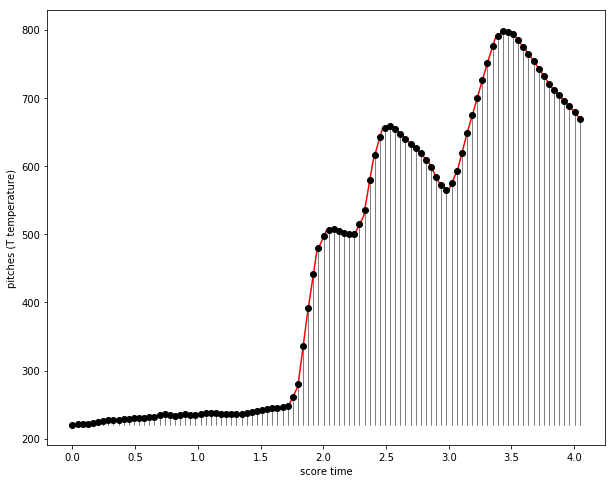

In [9]:
# plot the results: 

fig = plt.figure(figsize=(10,8))
time_tmp = np.linspace(times_sco[0],times_sco[-1],len(p1_f))
plt.plot(time_tmp,p1_f,'r-')
plt.plot(times_sco,pitches,'ko')
for ind,t in enumerate(times_sco):
    plt.plot([t,t],[f_min,pitches[ind]],'k-', linewidth=0.5)
    
plt.xlabel('score time')
plt.ylabel('pitches (T temperature)')

In [14]:
# (4) write RTcmix Wavetable score
reload(wRT_wt)
base_name = 'test_noRhythm1'

tones_dict = {}
tones_dict['times'] = np.asarray(times_sco)
tones_dict['notes'] = np.asarray(pitches)
tones_dict['durs'] = np.ones(len(pitches))*dt*1.0 # the 0.8 makes for more discrete pitches
tones_dict['amps'] = np.ones(len(pitches))*2000
tones_dict['pans'] = np.ones(len(pitches))*0.5

score_name = wRT_wt.writesco(tones_dict,base_name)

test_noRhythm1.sco
CMIX found.
rtoutput("test_noRhythm1.wav")



In [15]:
cmix_cmd = 'CMIX < ' + score_name
print(cmix_cmd)

# the ! tells the notebook to run a command in the terminal
! pwd
! ls *.sco
# or if that doesnt work, try this: 
ls_output = sp.check_output(['pwd'])
print(ls_output)
# but THIS works better ! 
! pwd

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
runCMIX.wait()
print("hopefully i just wrote your sound file; is it here?")
! ls *.wav

sp.run(['mv', score_name, '../3_output_nogit'])
sp.run('mv *.wav ../3_output_nogit/', shell=True)

CMIX < test_noRhythm1.sco
/Users/ben/githole/datamovies/1_codes
lern_GRANSYNTH_v1_pitchjitVAR.sco test_noRhythm1.sco
scale1_RT.sco
b'/Users/ben/githole/datamovies/1_codes\n'
/Users/ben/githole/datamovies/1_codes
hopefully i just wrote your sound file; is it here?
scale1_RT.wav      test_noRhythm1.wav


CompletedProcess(args='mv *.wav ../3_output_nogit/', returncode=0)

## 3) Got Rhythm ! pitches determine time !  

(1) Define the frequencies that we want to use ! <br>
(2) Interpolate the y values to this range of frequencies. <br>
(3) Find where in time these values occur, use these as our start times and durations.  <br>
(4) Generate the score. <br>

In [10]:
n_octaves_total = 3.0
root_note  = 110.0
ints_per_oct = 24

# chromatic scale of n octaves: 
intervals = np.linspace(0,n_octaves_total,int(n_octaves_total*ints_per_oct))
pitches = root_note*(2**intervals)
print(pitches)

# or... major scales of n octaves, etc... 



[110.         113.26931196 116.63579119 120.10232562 123.67188897
 127.34754339 131.13244199 135.02983163 139.04305566 143.17555679
 147.43088006 151.81267587 156.32470311 160.97083239 165.75504936
 170.68145813 175.75428479 180.97788101 186.35672783 191.89543945
 197.59876722 203.4716037  209.51898685 215.74610439 222.15829819
 228.76106893 235.56008073 242.56116608 249.77033081 257.19375925
 264.83781955 272.70906909 280.81426019 289.16034581 297.75448559
 306.60405195 315.71663644 325.1000562  334.76236076 344.71183884
 354.95702553 365.5067096  376.36994102 387.55603873 399.07459865
 410.9355019  423.14892326 435.72533993 448.67554051 462.01063424
 475.74206051 489.88159876 504.44137847 519.43388965 534.87199353
 550.76893356 567.13834683 583.99427573 601.35117999 619.2239491
 637.62791511 656.57886572 676.09305787 696.18723166 716.87862476
 738.18498712 760.12459625 782.7162729  805.97939717 829.93392517
 854.60040613 880.        ]


Text(0, 0.5, 'pitches (T temperature)')

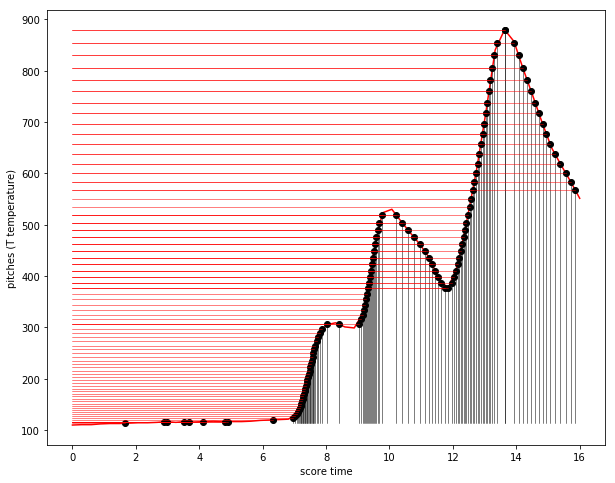

In [11]:
# (2) Interpolate the y-values to a range of frequency (using notepicker !)
reload(notepicker)
p1_in_freq = notepicker.interpvals_to_freqs(p1,pitches)

# (3) Find where in time these values occur, use these as our start times and durations.
dur_sound = 16.0
time = np.linspace(0,dur_sound,len(p1_in_freq))
scale_note_dur = 0.8
times, notes, durs = notepicker.findroots(time,p1_in_freq,pitches)


# plot the results: 
fig = plt.figure(figsize=(10,8))

time_tmp = np.linspace(time[0],time[-1],len(p1_in_freq))
plt.plot(time_tmp,p1_in_freq,'r-')
plt.plot(times,notes,'ko')

for ind,t in enumerate(times):
    plt.plot([t,t],[min(notes),notes[ind]],'k-',linewidth=0.5)
    plt.plot([0,t],[notes[ind],notes[ind]],'r-',linewidth=0.5)
    
plt.xlabel('score time')
plt.ylabel('pitches (T temperature)')

In [12]:
# (4) write RTcmix Wavetable score
reload(wRT_wt)
base_name = 'test_gotRhythm1'
trim = -6
tones_dict = {}
tones_dict['times'] = np.asarray(times[:trim])
tones_dict['notes'] = np.asarray(notes[:trim])
tones_dict['durs'] = np.asarray(durs[:trim]) 
tones_dict['amps'] = np.ones(len(notes[:trim]))*2000
tones_dict['pans'] = np.ones(len(notes[:trim]))*0.5

score_name = wRT_wt.writesco(tones_dict,base_name)

test_gotRhythm1.sco
CMIX not found; rtoutput() will not be used in score.


In [19]:
cmix_cmd = 'CMIX < ' + score_name
print(cmix_cmd)

# the ! tells the notebook to run a command in the terminal
! pwd
! ls *.sco
# or if that doesnt work, try this: 
ls_output = sp.check_output(['pwd'])
print(ls_output)
# but THIS works better ! 
! pwd

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
runCMIX.wait()
print("hopefully i just wrote your sound file; is it here?")
! ls *.wav

sp.run(['mv', score_name, '../3_output_nogit'])
sp.run('mv *.wav ../3_output_nogit/', shell=True)

CMIX < test_gotRhythm1.sco
/Users/ben/githole/datamovies/1_codes
lern_GRANSYNTH_v1_pitchjitVAR.sco test_gotRhythm1.sco
scale1_RT.sco
b'/Users/ben/githole/datamovies/1_codes\n'
/Users/ben/githole/datamovies/1_codes
hopefully i just wrote your sound file; is it here?
test_gotRhythm1.wav


CompletedProcess(args='mv *.wav ../3_output_nogit/', returncode=0)

### (4) Swelling chords

In [13]:
# OR USE OTHER MUSICAL STRUCTURES ! 
modes = {
    'ionian':[2,2,1,2,2,2,1],
    'dorian':[2,1,2,2,2,1,2],
    'phrygian':[1,2,2,2,1,2,2],
    'lydian':[2,2,2,1,2,2,1],
    'mixolydian':[2,2,1,2,2,1,2],
    'aeolian':[2,1,2,2,1,2,2],
    'lochrian':[1,2,2,1,2,2,2]
}

intervals = [0] + modes['phrygian'] + modes['phrygian']+ modes['lydian'] # + modes['mixolydian']
print(intervals)
elements = np.cumsum(intervals[:-1])
print(elements)
#indexes = np.array(x)

C4 = 440.0 * 2**(3/12-1)
print(C4)

def notename2freq(k,v,f0):
    freqs = f0*2**(v+k/12)
    return freqs

pitches = notename2freq(elements,-1,C4)
print(pitches)

[0, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1]
[ 0  1  3  5  7  8 10 12 13 15 17 19 20 22 24 26 28 30 31 33 35]
261.6255653005986
[130.81278265 138.59131549 155.56349186 174.61411572 195.99771799
 207.65234879 233.08188076 261.6255653  277.18263098 311.12698372
 349.22823143 391.99543598 415.30469758 466.16376152 523.2511306
 587.32953583 659.25511383 739.98884542 783.99087196 880.
 987.76660251]


In [14]:
reload(notepicker)
dur = 20.0
scale_note_dur = 1.0

p1_freq = notepicker.interpvals_to_freqs(p1,pitches)

times, notes, durs = notepicker.findroots(time,p1_freq,pitches)
# for t in range(len(times)):
#     if times[t] > time[-1]:
#         times[t] = time[-1]
        
# print(times)
# print(notes)

In [15]:
print(time[-1])

print(len(pitches))
print(len(time))
print(len(times))
print(len(notes))

16.0
21
55
34
34


[138.59131549 155.56349186 174.61411572 195.99771799 207.65234879
 233.08188076 261.6255653  277.18263098 311.12698372 349.22823143
 391.99543598 415.30469758 466.16376152 523.2511306  587.32953583
 587.32953583 523.2511306  466.16376152 415.30469758 415.30469758
 466.16376152 523.2511306  587.32953583 659.25511383 739.98884542
 783.99087196 880.         987.76660251 987.76660251 987.76660251
 880.         783.99087196 739.98884542 659.25511383]
[  16.97217637   18.01140011   20.21711306   16.51911654   18.54208138
   26.98660826   22.05037511   24.75070921   36.02280023   40.43422613
   33.03823307   37.08416277   53.97321651   60.58288716   32.03920262
  -32.03920262  -60.58288716  -53.97321651  -25.42953197   25.42953197
   53.97321651   60.58288716   68.00199161   76.32965479   62.36787907
   70.00557729  101.88786527   53.88330126    0.          -53.88330126
 -101.88786527  -70.00557729  -62.36787907  -80.7337316 ]
34


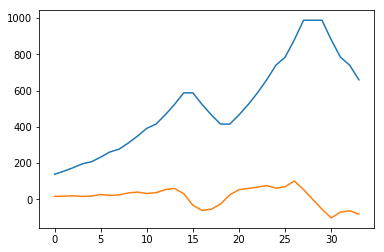

In [19]:
# development
print(notes)
diff_notes = np.gradient(notes)
print(diff_notes)
print(len(diff_notes))
plt.plot(notes)
plt.plot(diff_notes)

In [33]:
# run makeDataChord
import makeDataChord_v2 as mDc
reload(mDc)

ch_notes, ch_times, ch_durs = mDc.makeDataChord(pitches,time,times,notes)
print(len(ch_durs))

# plot the results: 
fig = plt.figure(figsize=(10,8))

plt.plot(time,p1_freq, 'r-')
plt.plot(times,notes,'ko')

for i in range(len(ch_notes)):
    plt.plot([ch_times[i],ch_times[i]+ch_durs[i]],[ch_notes[i],ch_notes[i]],'k-', linewidth=0.5)

[ 0.05063291]
now looping over the next note_times:
time = 0.0506329113924
ind_time = 0
[ 0.52487638  0.66791881  1.02492417]
now looping over the next note_times:
time = 0.524876377342
ind_time = 1
time = 0.667918814783
ind_time = 2
time = 1.02492416882
ind_time = 3
[ 1.38188731]
now looping over the next note_times:
time = 1.38188731211
ind_time = 4
[ 1.5037426]
now looping over the next note_times:
time = 1.50374259851
ind_time = 5
[ 1.61891128]
now looping over the next note_times:
time = 1.61891127956
ind_time = 6
[  1.84276635  14.07594937  14.15848541]
now looping over the next note_times:
time = 1.8427663463
ind_time = 7


IndexError: index 8 is out of bounds for axis 0 with size 3

In [67]:
reload(wRT_wt)
base_name = 'test_dataChords'
tones_dict = {}
tones_dict['times'] = np.asarray(ch_times)
tones_dict['notes'] = np.asarray(ch_notes)
tones_dict['durs'] = np.asarray(ch_durs)
tones_dict['amps'] = np.ones(len(ch_notes))*2000
tones_dict['pans'] = np.ones(len(ch_notes))*0.5

score_name = wRT_wt.writesco(tones_dict,base_name)

test_dataChords.sco
CMIX found.
rtoutput("test_dataChords.wav")



In [68]:
cmix_cmd = 'CMIX < ' + score_name
print(cmix_cmd)

# the ! tells the notebook to run a command in the terminal (this does not work in a script!)
! pwd
! ls *.sco
# or if that doesnt work, try this: 
ls_output = sp.check_output(['pwd'])

print(ls_output)
# but THIS works better ! 
! pwd

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
runCMIX.wait()
print("hopefully i just wrote your sound file; is it here?")
! ls *.wav

sp.run(['mv', score_name, '../3_output_nogit/'])
sp.run('mv *.wav ../3_output_nogit/', shell=True)


CMIX < test_dataChords.sco
/Users/ben/githole/datamovies/1_codes
test_dataChords.sco
b'/Users/ben/githole/datamovies/1_codes\n'
/Users/ben/githole/datamovies/1_codes
hopefully i just wrote your sound file; is it here?
test_dataChords.wav


CompletedProcess(args=['mv', '*.wav', '../3_output_nogit/'], returncode=64)

CompletedProcess(args='mv *.wav ../3_output_nogit/', returncode=0)